In [1]:
import argparse
import pandas as pd
import numpy as np
from numpy import savez_compressed, load
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from functools import reduce
en_stopwords = set(stopwords.words('english')) 
import itertools
import re
import time
import os
import pickle

import datasets
from datasets import load_dataset, load_metric, Dataset, concatenate_datasets,DatasetDict
from datasets import load_from_disk
from tqdm import tqdm
tqdm.pandas(position=0,leave=True)


import textwrap

import transformers

from transformers import (
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    get_linear_schedule_with_warmup,
)
print("Transformers version is {}".format(transformers.__version__))

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import display, HTML

from collections import Counter
from wordcloud import WordCloud

sns.set(style="whitegrid",palette='muted',font_scale=1.2)
rcParams['figure.figsize']=16,10

%config InlineBackend.figure_format="retina"
%matplotlib inline

pd.set_option('display.max_columns', None,'display.max_rows',None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Transformers version is 4.17.0


In [2]:
my_folder="s3://trident-retention-output/"
folder = 's3://trident-retention-data/askunum/'
churn_data=pd.read_pickle(os.path.join(my_folder,"churn_data_pickle"))
churn_data.head()

unum_id  policy_id pivot_date  year  month start_date   end_date  churn
0  GRA00956433     956433 2021-08-01  2021      8 2020-11-01 2021-05-01      1
1  GRA00956388     956388 2021-06-01  2021      6 2020-09-01 2021-03-01      1
2  GRA00955945     955945 2021-01-01  2021      1 2020-04-01 2020-10-01      1
3  GRA00955705     955705 2020-09-01  2020      9 2019-12-01 2020-06-01      1
4  GRA00955115     955115 2020-03-01  2020      3 2019-06-01 2019-12-01      1

In [3]:
email_all=load_from_disk(os.path.join(os.getcwd(),"dataset","email_all"))
email_all

DatasetDict({
    train: Dataset({
        features: ['unum_id', 'policy_id', 'Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'month', 'email_counts', 'issue_counts', 'duration', 'subtype', 'churn'],
        num_rows: 143551
    })
    test: Dataset({
        features: ['unum_id', 'policy_id', 'Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'month', 'email_counts', 'issue_counts', 'duration', 'subtype', 'churn'],
        num_rows: 25246
    })
})

In [4]:
train_data=email_all['train']
test_data=email_all['test']
train_data.set_format(type="pandas")
df_train=train_data[:]
test_data.set_format(type="pandas")
df_test=test_data[:]

In [5]:
tempt1=pd.DataFrame(df_train["churn"].value_counts(dropna=False)).reset_index().rename(columns={'index':'churn','churn':'count'})
tempt2=pd.DataFrame(df_train["churn"].value_counts(dropna=False,normalize=True)).reset_index().rename(columns={'index':'churn','churn':'percentage'})
tempt1.merge(tempt2, on="churn", how="inner").style.format({'count':'{:,}','percentage':'{:.2%}'}).set_caption("Training set churn dist")\
.set_table_styles([{'selector': 'caption','props': [('color', 'red'),('font-size', '15px')]}])

In [6]:
tempt1=pd.DataFrame(df_test["churn"].value_counts(dropna=False)).reset_index().rename(columns={'index':'churn','churn':'count'})
tempt2=pd.DataFrame(df_test["churn"].value_counts(dropna=False,normalize=True)).reset_index().rename(columns={'index':'churn','churn':'percentage'})
tempt1.merge(tempt2, on="churn", how="inner").style.format({'count':'{:,}','percentage':'{:.2%}'}).set_caption("Test set churn dist")\
.set_table_styles([{'selector': 'caption','props': [('color', 'red'),('font-size', '15px')]}])

In [7]:
df_train.head()

unum_id  policy_id                                      Full_TextBody  \
0  158757547     403324  . . you have received an encrypted message fro...   
1  122323585     604582  . . hello, could we please get the eoi form th...   
2     791399     217586  name sonya marsh phone 804-249-5412 response r...   
3     611560     933183  . . this message was sent securely using zix h...   
4  635710940     658785  . . good afternoon, please process the attache...   

                                     Client_TextBody  \
0  . . you have received an encrypted message fro...   
1  . . hello, could we please get the eoi form th...   
2  name sonya marsh phone 804-249-5412 response r...   
3  . . this message was sent securely using zix h...   
4  . . good afternoon, please process the attache...   

                                     Latest_TextBody  year  month  \
0  . . you have received an encrypted message fro...  2020      1   
1  re 604581,604582 hello melissa, . for amplify ...  2020      7   
2  re 217586 hi sonya, . i needed to correct the ...  2019      3   
3  re r0364752, 933183, r0091074 greetings lisa, ...  2021      5   
4  . . good morning, this members enrollment is s...  2020      2   

   email_counts  issue_counts   duration                 subtype  churn  
0            12            11  10.671863   Enrollment Submission      0  
1             3             3   3.384468          EOI Submission      0  
2             1             1   5.015174         Employee Coding      0  
3             1             2   1.124016  GPC â Client Request      0  
4            20            19  19.037338         Employee Coding      1

In [8]:
from datasets import Dataset
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)

In [9]:
train_df1=Dataset.from_pandas(df_train)
train_df1=train_df1.map(lambda x: tokenizer(x["Full_TextBody"]),batched=True)

test_df1=Dataset.from_pandas(df_test)
test_df1=test_df1.map(lambda x: tokenizer(x["Full_TextBody"]),batched=True)

def compute_lenth(example):
    return {"text_length":len(example["input_ids"])}
train_df1=train_df1.map(compute_lenth)
test_df1=test_df1.map(compute_lenth)

  0%|          | 0/144 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (5923 > 4096). Running this sequence through the model will result in indexing errors


  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/143551 [00:00<?, ?ex/s]

  0%|          | 0/25246 [00:00<?, ?ex/s]

In [10]:
train_df2=Dataset.from_pandas(df_train)
train_df2=train_df2.filter(lambda x: x["Client_TextBody"]!=None)
train_df2=train_df2.map(lambda x: tokenizer(x["Client_TextBody"]),batched=True)

test_df2=Dataset.from_pandas(df_test)
test_df2=test_df2.filter(lambda x: x["Client_TextBody"]!=None)
test_df2=test_df2.map(lambda x: tokenizer(x["Client_TextBody"]),batched=True)

def compute_lenth(example):
    return {"text_length":len(example["input_ids"])}
train_df2=train_df2.map(compute_lenth)
test_df2=test_df2.map(compute_lenth)

  0%|          | 0/144 [00:00<?, ?ba/s]

  0%|          | 0/144 [00:00<?, ?ba/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/143551 [00:00<?, ?ex/s]

  0%|          | 0/25246 [00:00<?, ?ex/s]

In [11]:
train_df3=Dataset.from_pandas(df_train)
train_df3=train_df3.map(lambda x: tokenizer(x["Latest_TextBody"]),batched=True)

test_df3=Dataset.from_pandas(df_test)
test_df3=test_df3.map(lambda x: tokenizer(x["Latest_TextBody"]),batched=True)

def compute_lenth(example):
    return {"text_length":len(example["input_ids"])}
train_df3=train_df3.map(compute_lenth)
test_df3=test_df3.map(compute_lenth)

  0%|          | 0/144 [00:00<?, ?ba/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/143551 [00:00<?, ?ex/s]

  0%|          | 0/25246 [00:00<?, ?ex/s]

In [12]:
def statistics_compute(hf_df1,hf_df2,p=1):

    X=[]
    X.append(np.percentile(hf_df1['text_length'],p))
    X.append(np.percentile(hf_df2['text_length'],p))
    
    result={}
    result['percentile']=X
    result["min"]=[np.min(hf_df1['text_length']),np.min(hf_df2['text_length'])]
    result["max"]=[np.max(hf_df1['text_length']),np.max(hf_df2['text_length'])]
    result["mean"]=[np.mean(hf_df1['text_length']),np.mean(hf_df2['text_length'])]
    return result

def statistics_table(hf_df1,hf_df2):
    dict_data={}
    dict_data["data_type"]=["training", "test"]
    dict_data["# of obs"]=[len(hf_df1['text_length']),len(hf_df2['text_length'])]
    dict_data["Min of tokens"]=statistics_compute(hf_df1, hf_df2)["min"]
    dict_data["1% of tokens"]=statistics_compute(hf_df1, hf_df2, p=1)['percentile']
    dict_data["5% of tokens"]=statistics_compute(hf_df1, hf_df2, p=5)['percentile']
    dict_data["10% of tokens"]=statistics_compute(hf_df1, hf_df2, p=10)['percentile']
    dict_data["25% of tokens"]=statistics_compute(hf_df1, hf_df2, p=25)['percentile']
    dict_data["Median of tokens"]=statistics_compute(hf_df1, hf_df2, p=50)['percentile']
    dict_data["Average tokens"]=statistics_compute(hf_df1, hf_df2)["mean"]
    dict_data["75% of tokens"]=statistics_compute(hf_df1, hf_df2, p=75)['percentile']
    dict_data["90% of tokens"]=statistics_compute(hf_df1, hf_df2, p=90)['percentile']
    dict_data["95% of tokens"]=statistics_compute(hf_df1, hf_df2, p=95)['percentile']
    dict_data["99% of tokens"]=statistics_compute(hf_df1, hf_df2, p=99)['percentile']
    dict_data["Max of tokens"]=statistics_compute(hf_df1, hf_df2)["max"]
    token_count_df=pd.DataFrame(dict_data)
    return token_count_df

def style_format(token_count_df,  textbody="Full_TextBody"):
    token_count_df=token_count_df.set_index("data_type")
    token_count_df[list(token_count_df.columns)] = token_count_df[list(token_count_df.columns)].astype(int)
    return token_count_df.style.format("{:,}").set_caption(f"Summary Statistics of token lengths for {textbody} ").set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

In [13]:
token_count_df=statistics_table(train_df1,test_df1)
style_format(token_count_df,  textbody="Full_TextBody")

In [14]:
token_count_df=statistics_table(train_df2,test_df2)
style_format(token_count_df,  textbody="Client_TextBody")

In [15]:
token_count_df=statistics_table(train_df3,test_df3)
style_format(token_count_df,  textbody="Latest_TextBody")

In [16]:
train_df1.set_format("pandas")
df1_train=train_df1[:]
train_df2.set_format("pandas")
df2_train=train_df2[:]
train_df3.set_format("pandas")
df3_train=train_df3[:]

test_df1.set_format("pandas")
df1_test=train_df1[:]
test_df2.set_format("pandas")
df2_test=test_df2[:]
test_df3.set_format("pandas")
df3_test=test_df3[:]

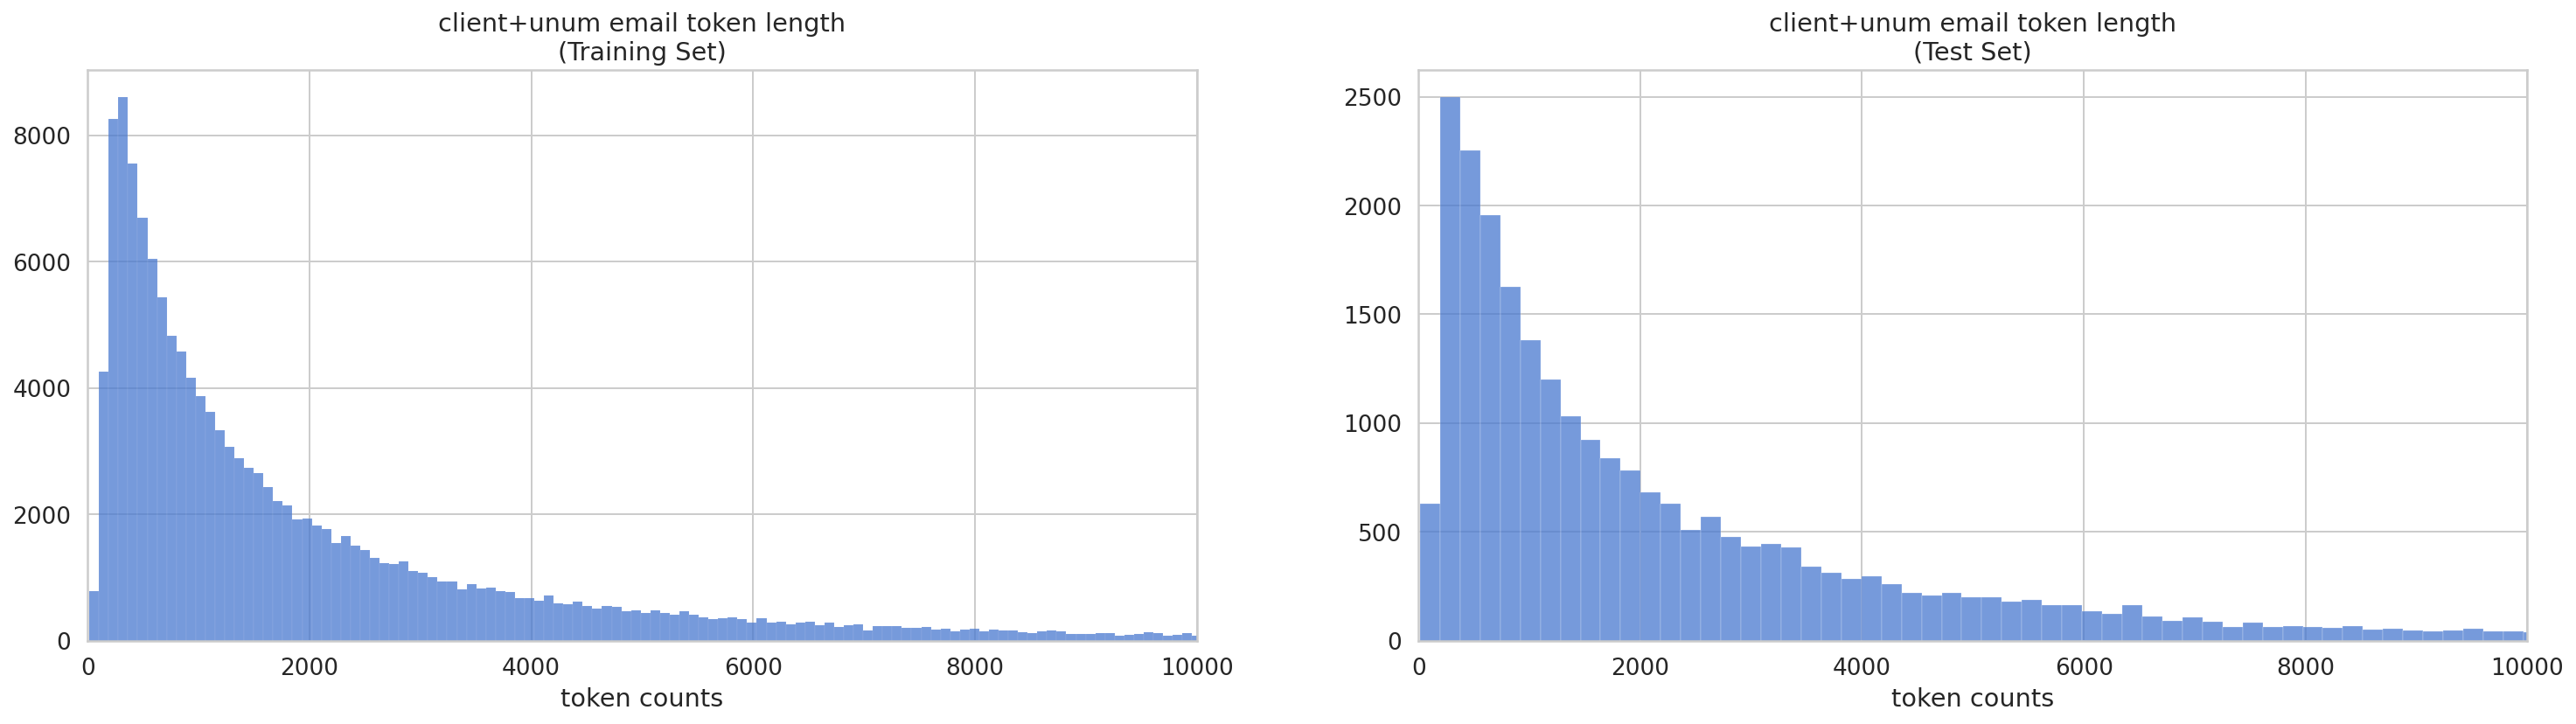

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(25,6))
sns.histplot(train_df1['text_length'],ax=ax1)
ax1.set_title("client+unum email token length\n(Training Set)")
ax1.set_xlabel("token counts")
ax1.set_ylabel("")
ax1.set(xlim=(0, 10000))

sns.histplot(test_df1['text_length'],ax=ax2)
ax2.set_title("client+unum email token length\n(Test Set)")
ax2.set_xlabel("token counts")
ax2.set_ylabel("")
ax2.set(xlim=(0, 10000))
plt.show()

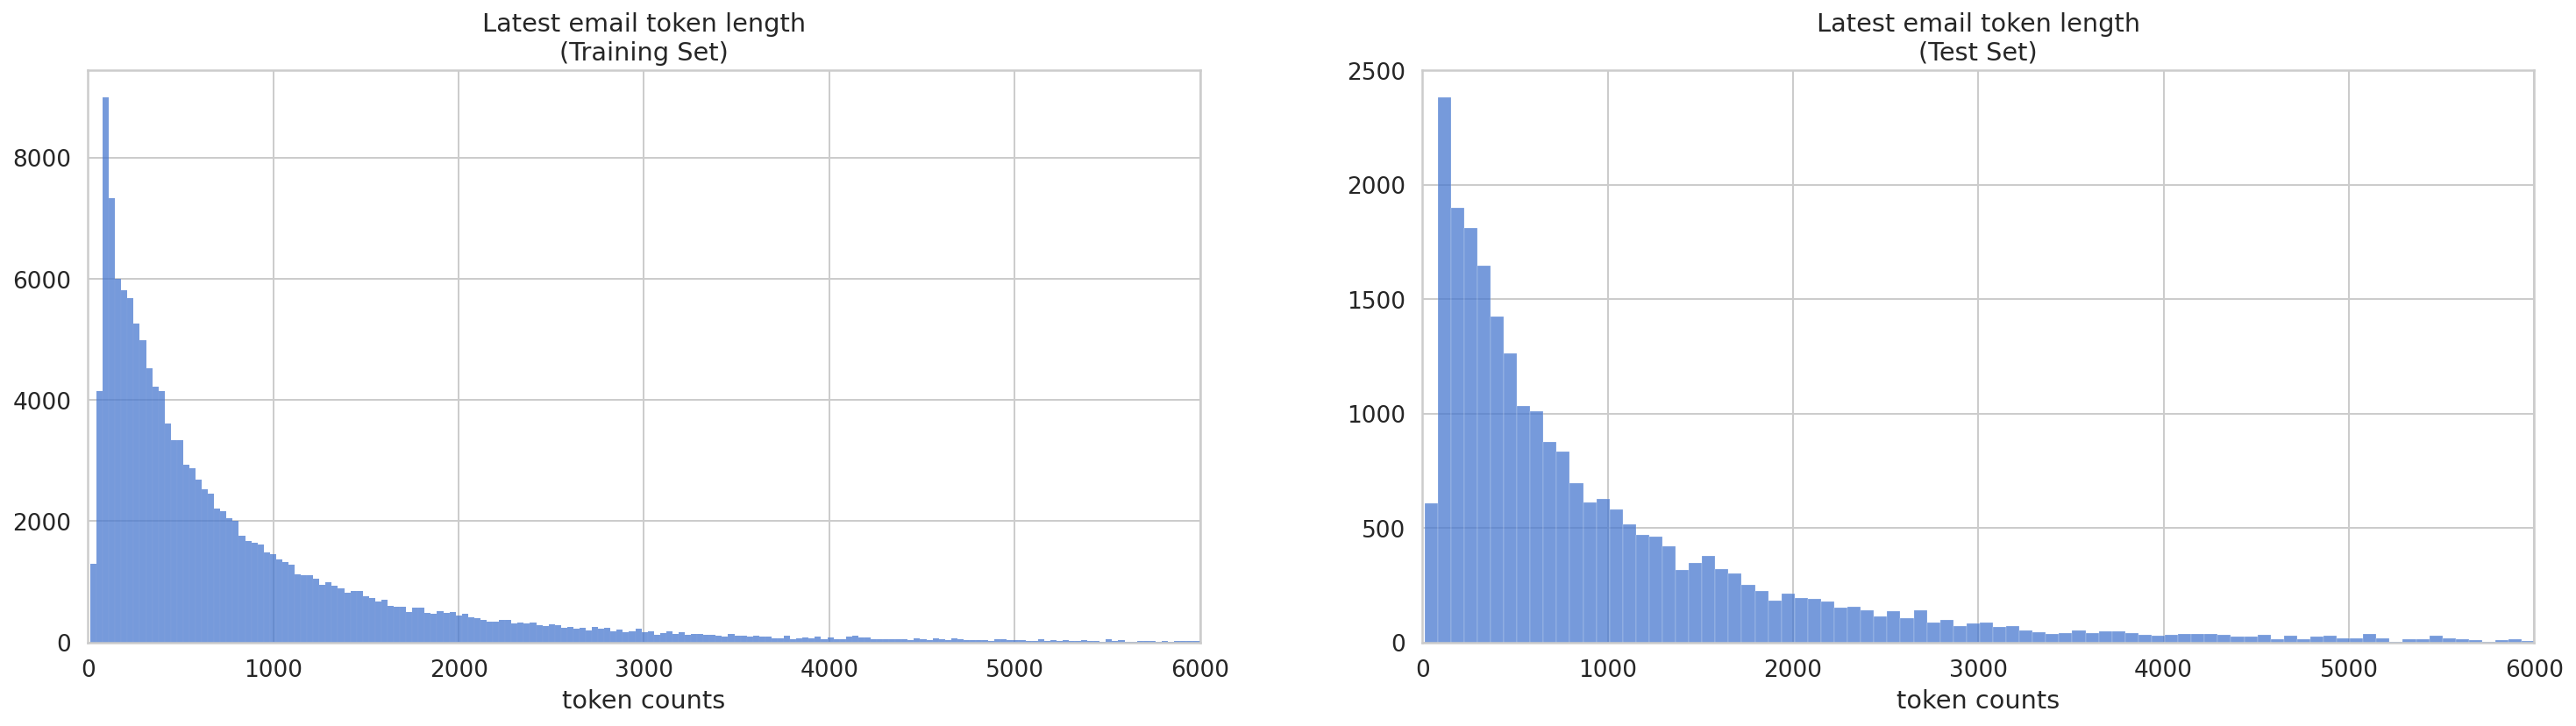

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(25,6))
sns.histplot(train_df3['text_length'],ax=ax1)
ax1.set_title("Latest email token length\n(Training Set)")
ax1.set_xlabel("token counts")
ax1.set_ylabel("")
ax1.set(xlim=(0, 6000))

sns.histplot(test_df3['text_length'],ax=ax2)
ax2.set_title("Latest email token length\n(Test Set)")
ax2.set_xlabel("token counts")
ax2.set_ylabel("")
ax2.set(xlim=(0, 6000))
plt.show()

In [19]:
from datasets import Dataset
hf_train=Dataset.from_pandas(df_train)
hf_test=Dataset.from_pandas(df_test)
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
        
for text in ["Full_TextBody", "Latest_TextBody"]:
    hf_train=hf_train.map(lambda x : tokenizer(x[text]),batched=True)
    hf_train=hf_train.remove_columns("attention_mask")
    hf_train=hf_train.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    # hf_dataset = hf_dataset.filter(lambda x: len(x[text+"_input_ids"]) > self.min_tokens)
    
    hf_test=hf_test.map(lambda x : tokenizer(x[text]),batched=True)
    hf_test=hf_test.remove_columns("attention_mask")
    hf_test=hf_test.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    
hf_train.set_format(type="pandas")
df_train=hf_train[:]

hf_test.set_format(type="pandas")
df_test=hf_test[:]

  0%|          | 0/157 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4720 > 4096). Running this sequence through the model will result in indexing errors


  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

In [20]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS
all_stopwords_gensim = STOPWORDS.union(set(['thank','thanks', 'you', 'help','questions','a.m.','p.m.','friday','thursday','wednesday','tuesday','monday',\
                                            'askunum','email','askunum.com','unum','askunumunum.com','day','use', 'appreciate','available','mailtoaskunumunum.com',\
                                            'hello','hi','online','?','.','. .','phone','needs','need','let','know','service','information','time','meet','client',\
                                           'team','ask','file','date','opportunity','original','benefit','eastern','specialists','specialist','attached','experienced',\
                                            'benefits insurance','employee','click','organization','httpsbit.lycjrbm',  'received', 'billing', 'manager', 'assist', \
                                            'additional', 'response']))


## remove stop word
df_train["Full_TextBody"] = df_train["Full_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))
df_test["Full_TextBody"] = df_test["Full_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))

df_train["Latest_TextBody"] = df_train["Latest_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))
df_test["Latest_TextBody"] = df_test["Latest_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))

## removing non-english words from text
words = set(nltk.corpus.words.words())
df_train["Full_TextBody"] = df_train["Full_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))
df_test["Full_TextBody"] = df_test["Full_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))

df_train["Latest_TextBody"] = df_train["Latest_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))
df_test["Latest_TextBody"] = df_test["Latest_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))

## removing punctuation
df_train["Full_TextBody"]=df_train["Full_TextBody"].str.replace(r'[^\w\s]+', '')
df_test["Full_TextBody"]=df_test["Full_TextBody"].str.replace(r'[^\w\s]+', '')

df_train["Latest_TextBody"]=df_train["Full_TextBody"].str.replace(r'[^\w\s]+', '')
df_test["Latest_TextBody"]=df_test["Full_TextBody"].str.replace(r'[^\w\s]+', '')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
/home/

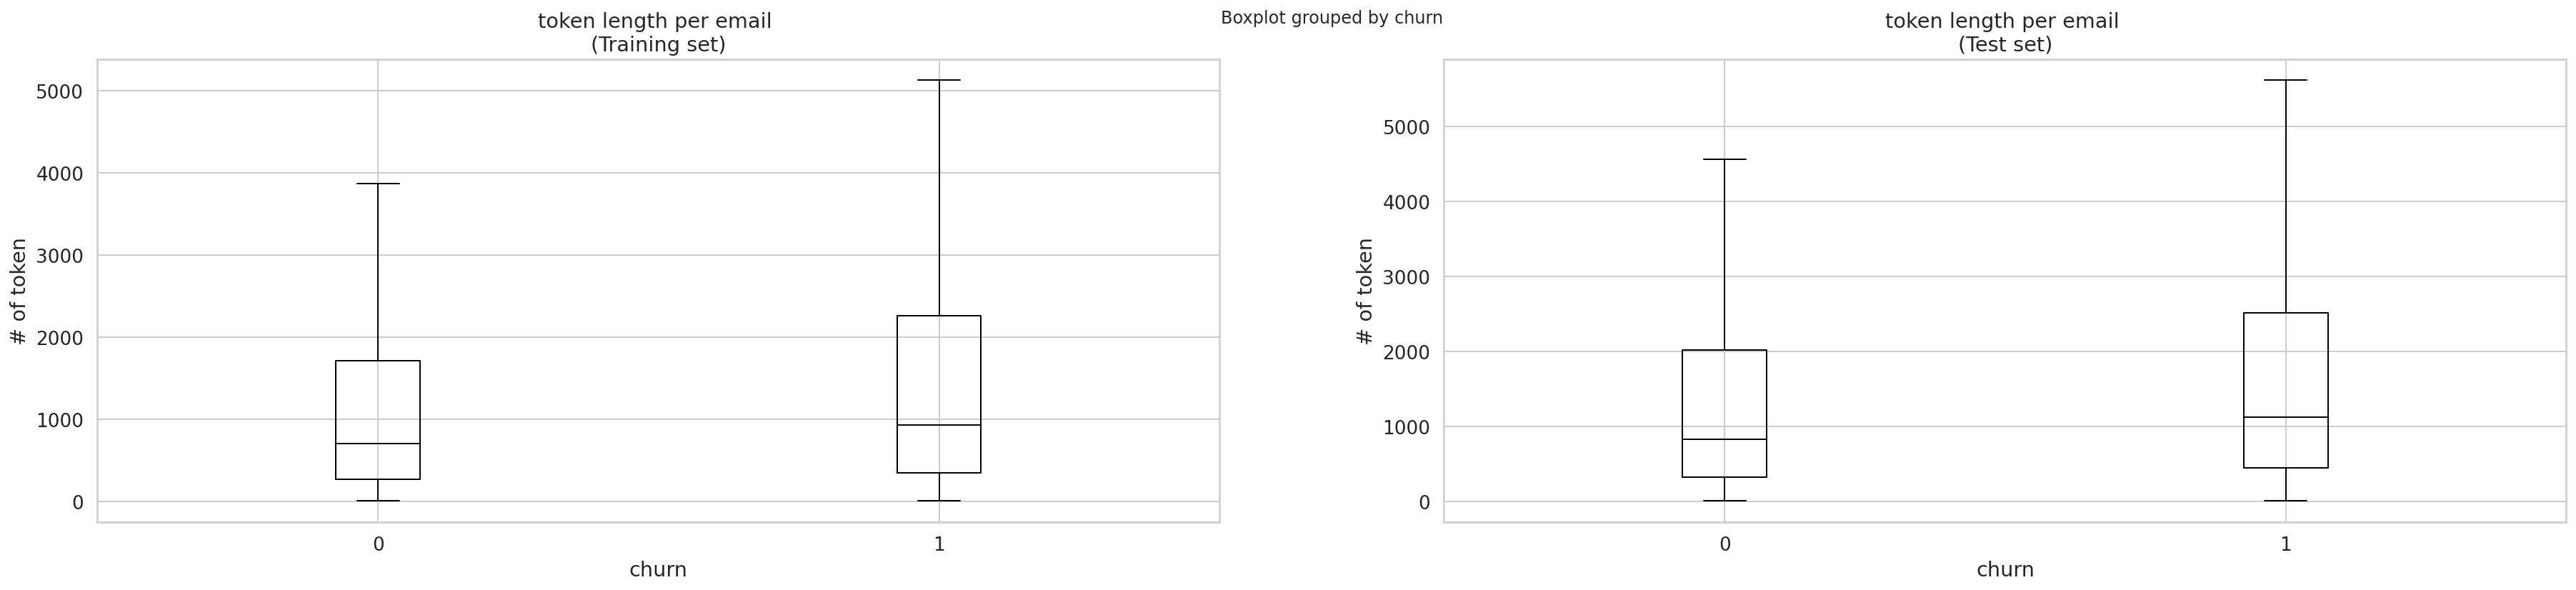

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(30,6))
df_train["Full_Words_length"] = df_train["Full_TextBody_input_ids"].apply(len)
df_train.boxplot("Full_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax1)
ax1.set_title("token length per email \n(Training set)")
ax1.set_ylabel("# of token")
df_test["Full_Words_length"] = df_test["Full_TextBody_input_ids"].apply(len)
df_test.boxplot("Full_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax2)
ax2.set_title("token length per email \n(Test set)")
ax2.set_ylabel("# of token")
plt.show()

100%|██████████| 156414/156414 [03:30<00:00, 743.73it/s]


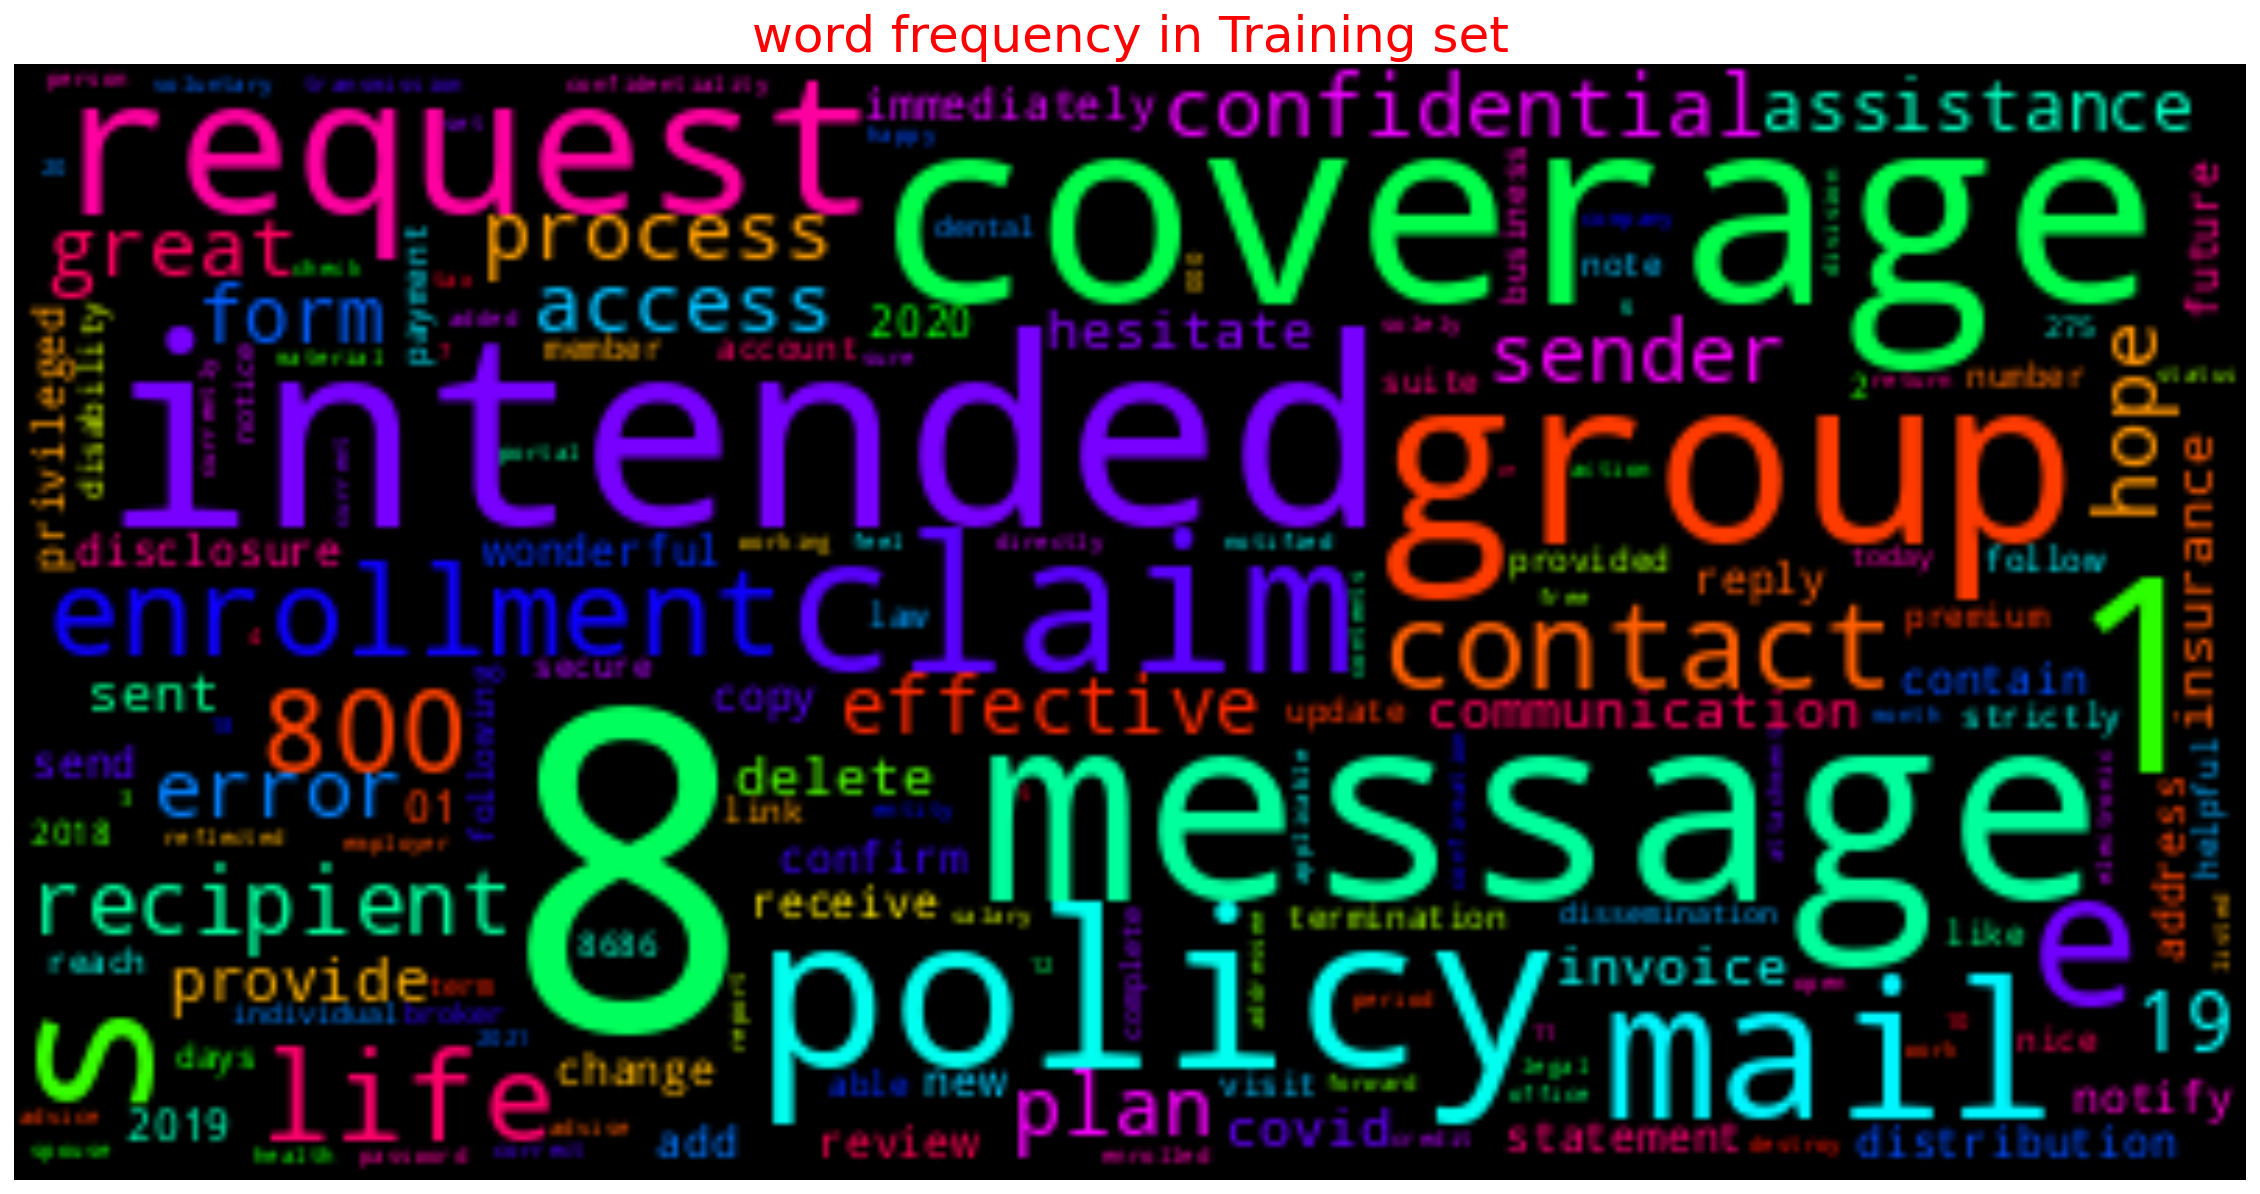

In [22]:
train_word=[]
for index, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    text_tokens = word_tokenize(row["Full_TextBody"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    # train_word.extend(filter_text.lower().split())
    train_word.extend(filter_text)
    
train_dict=Counter(train_word)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(train_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Training set", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

100%|██████████| 27497/27497 [00:41<00:00, 656.70it/s]


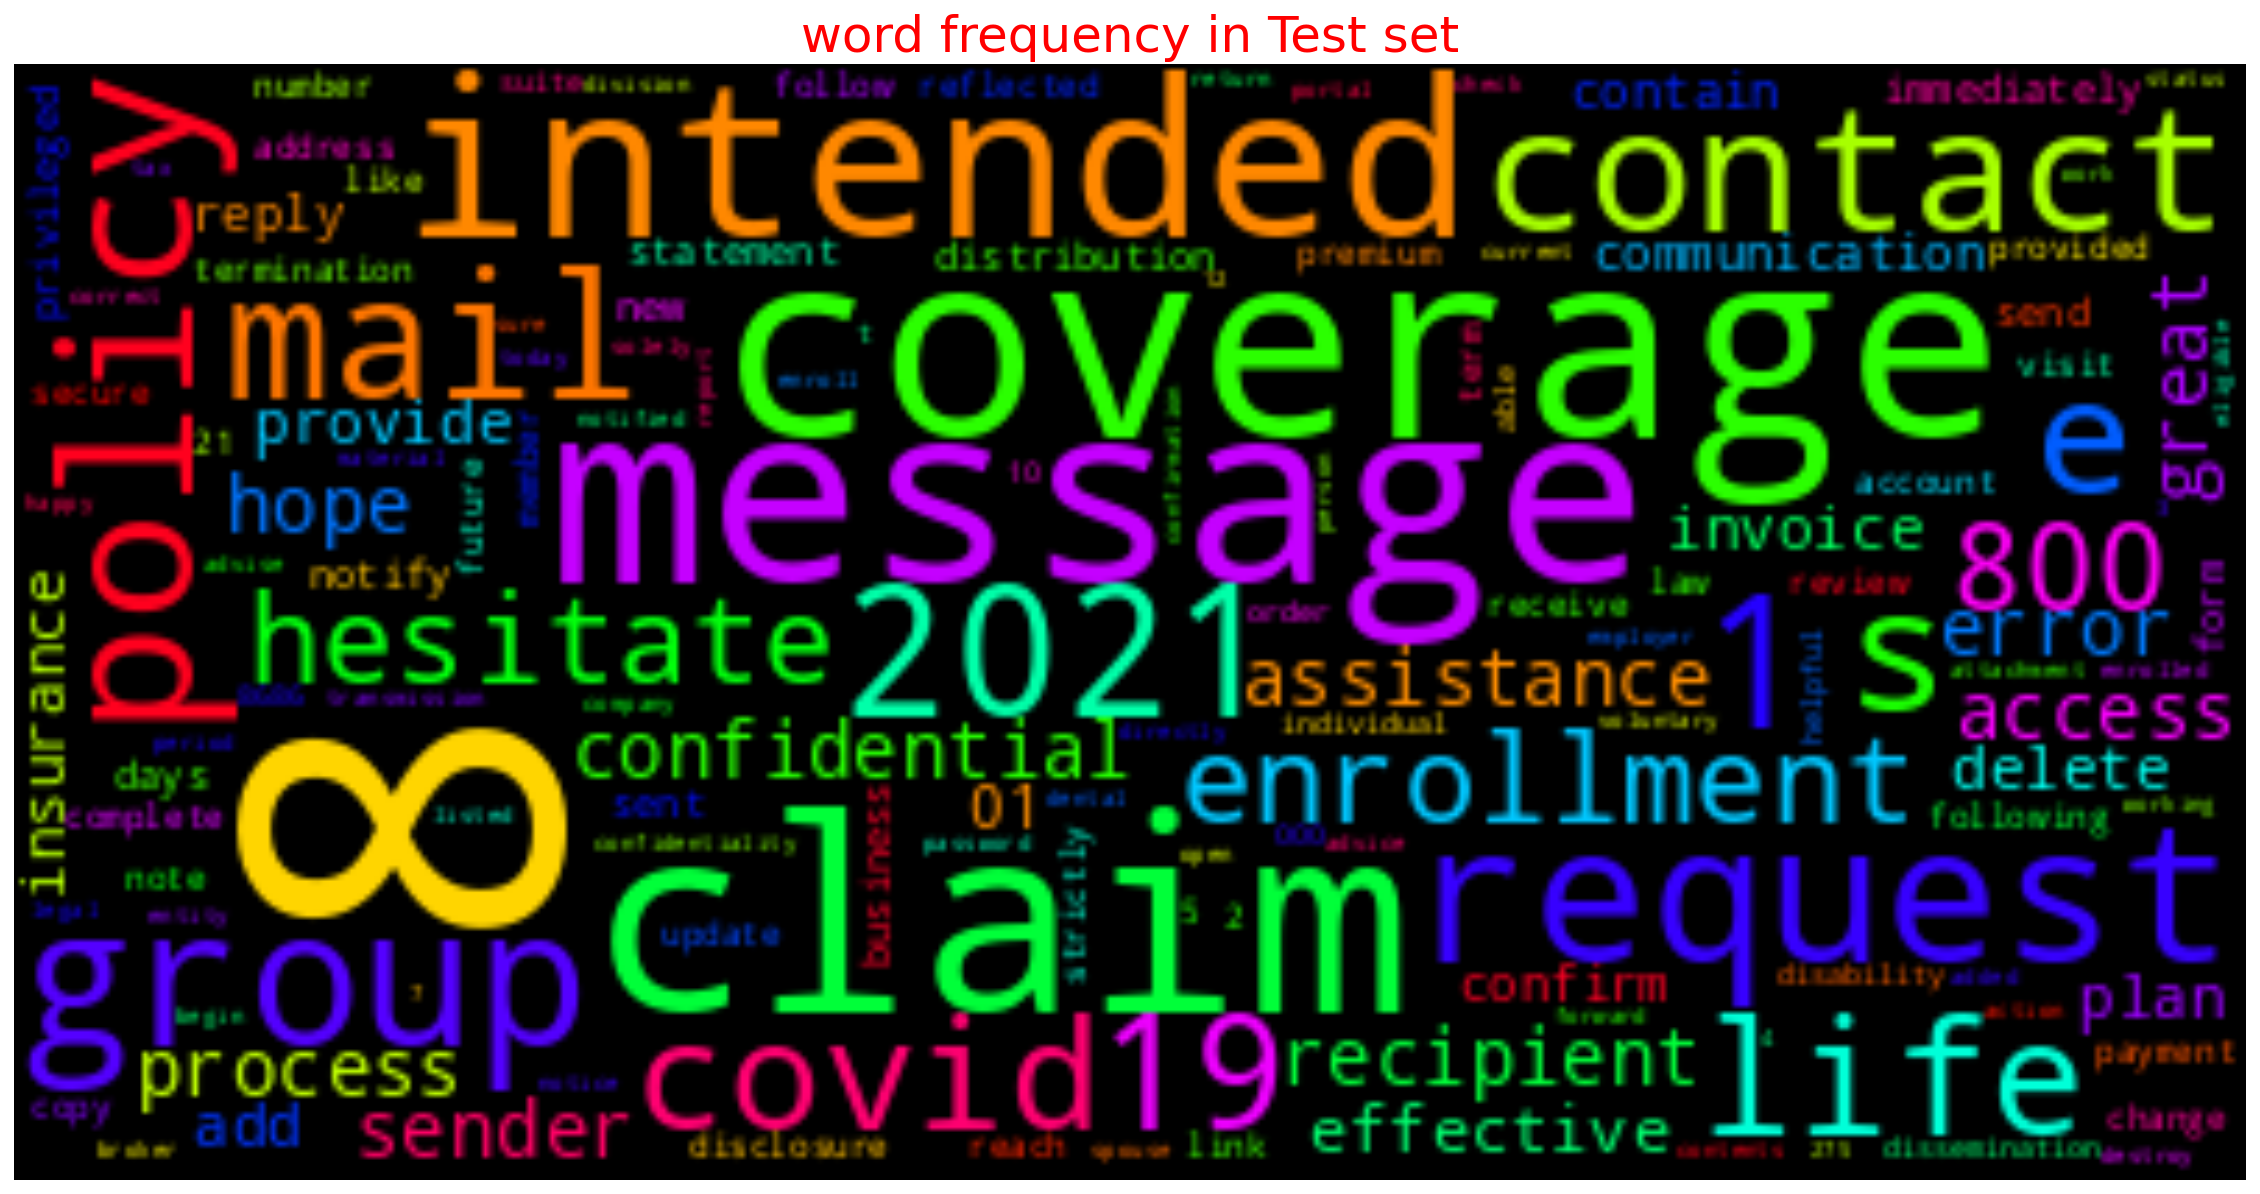

In [23]:
test_word=[]
for index, row in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    text_tokens = word_tokenize(row["Full_TextBody"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    # test_word.extend(filter_text.lower().split())
    test_word.extend(filter_text)
    
test_dict=Counter(test_word)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(test_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Test set", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

100%|██████████| 22510/22510 [00:35<00:00, 625.43it/s]


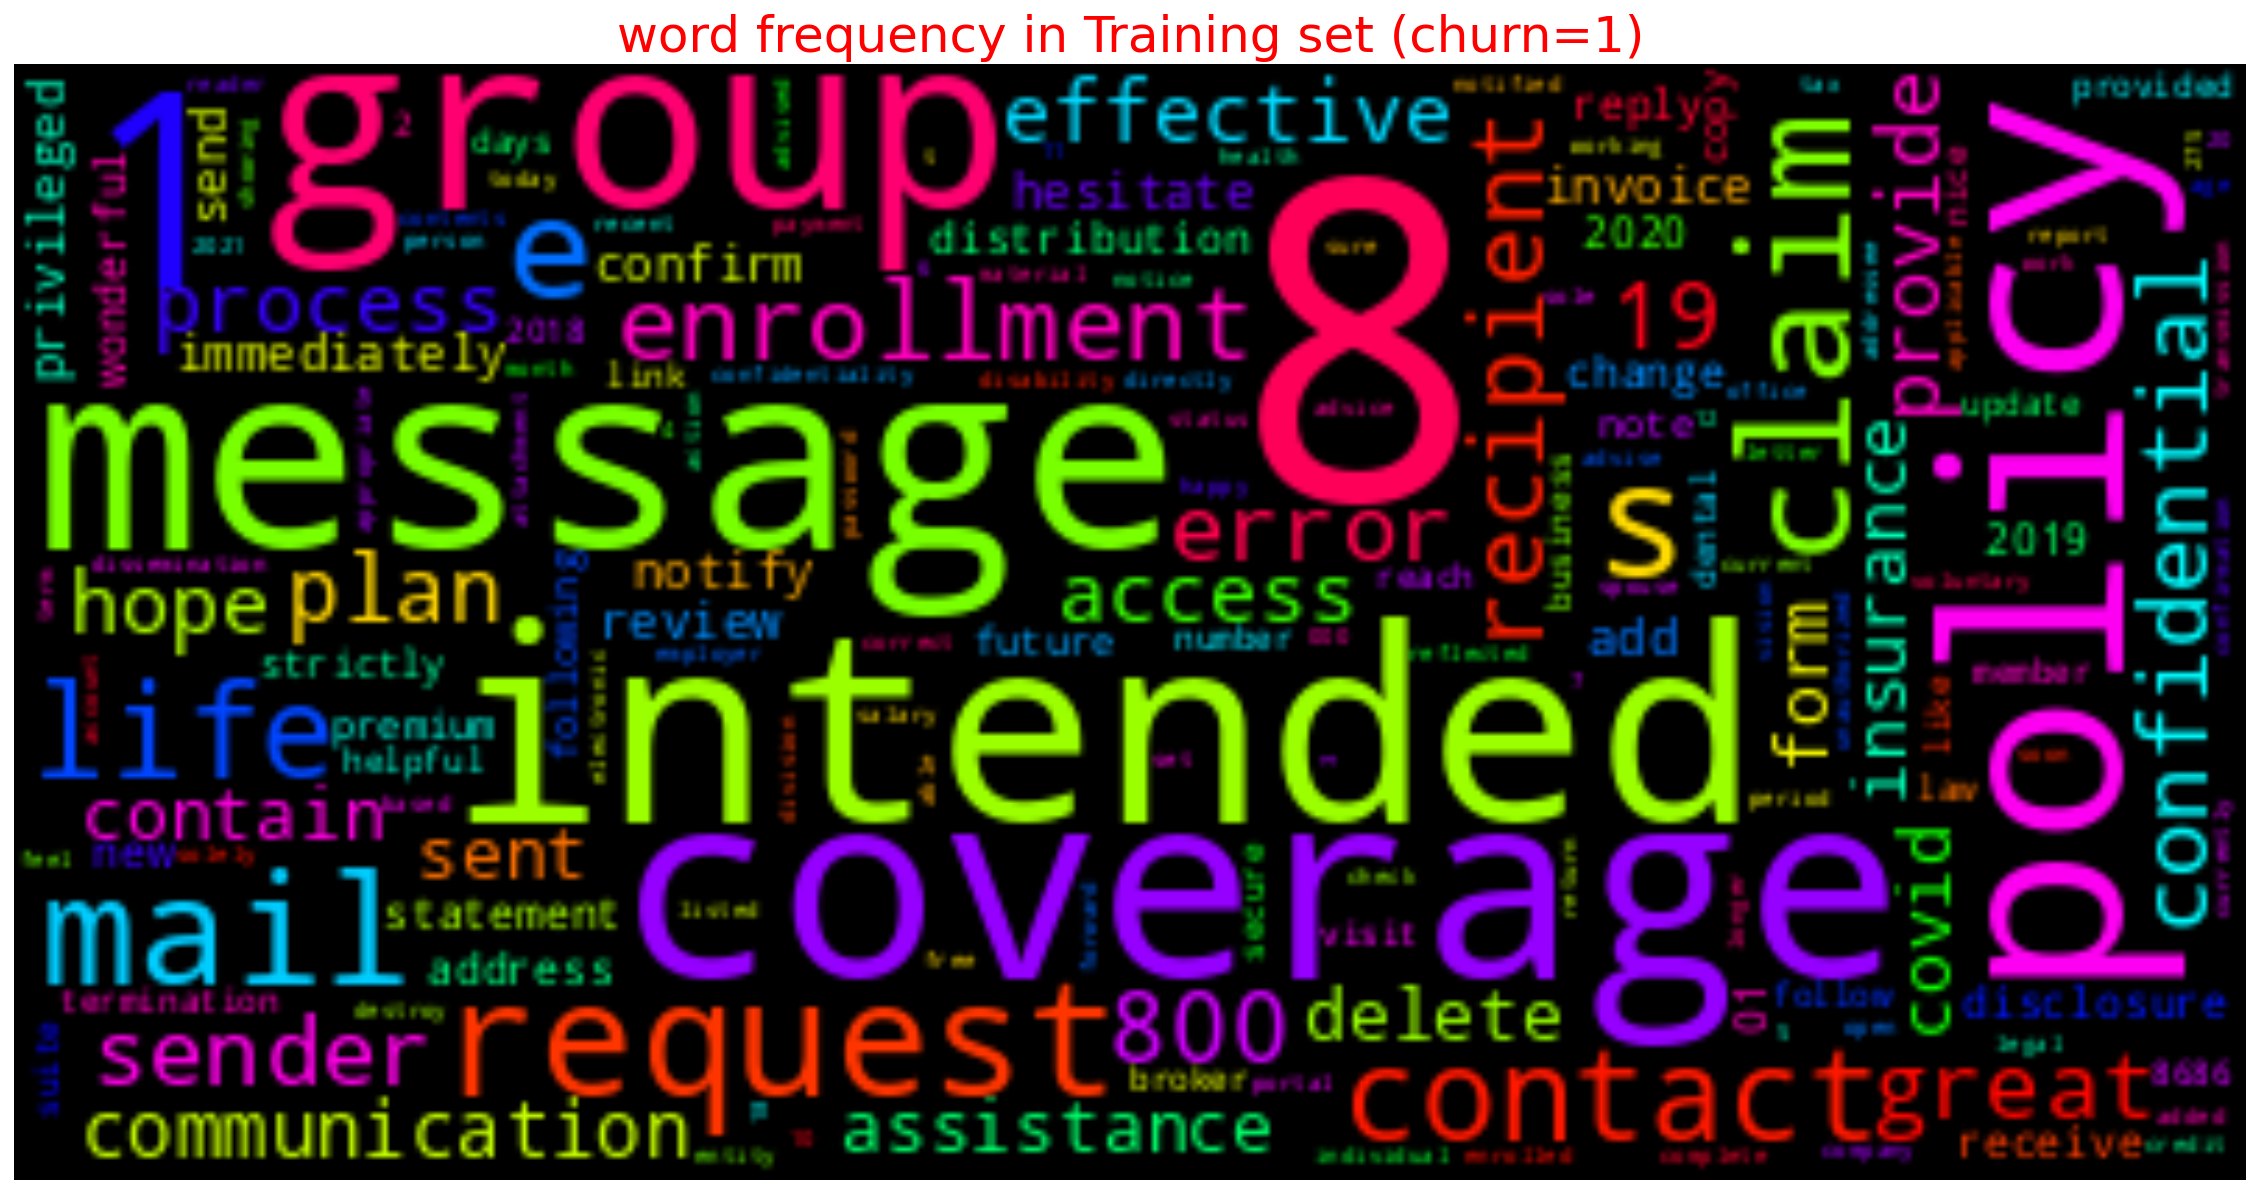

In [24]:
train_word_positive=[]
df_train_positive=df_train[df_train["churn"]==1]
for index, row in tqdm(df_train_positive.iterrows(), total=df_train_positive.shape[0]):
    text_tokens = word_tokenize(row["Full_TextBody"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    train_word_positive.extend(filter_text)
    
train_dict=Counter(train_word_positive)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(train_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Training set (churn=1)", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

100%|██████████| 3711/3711 [00:06<00:00, 558.98it/s]


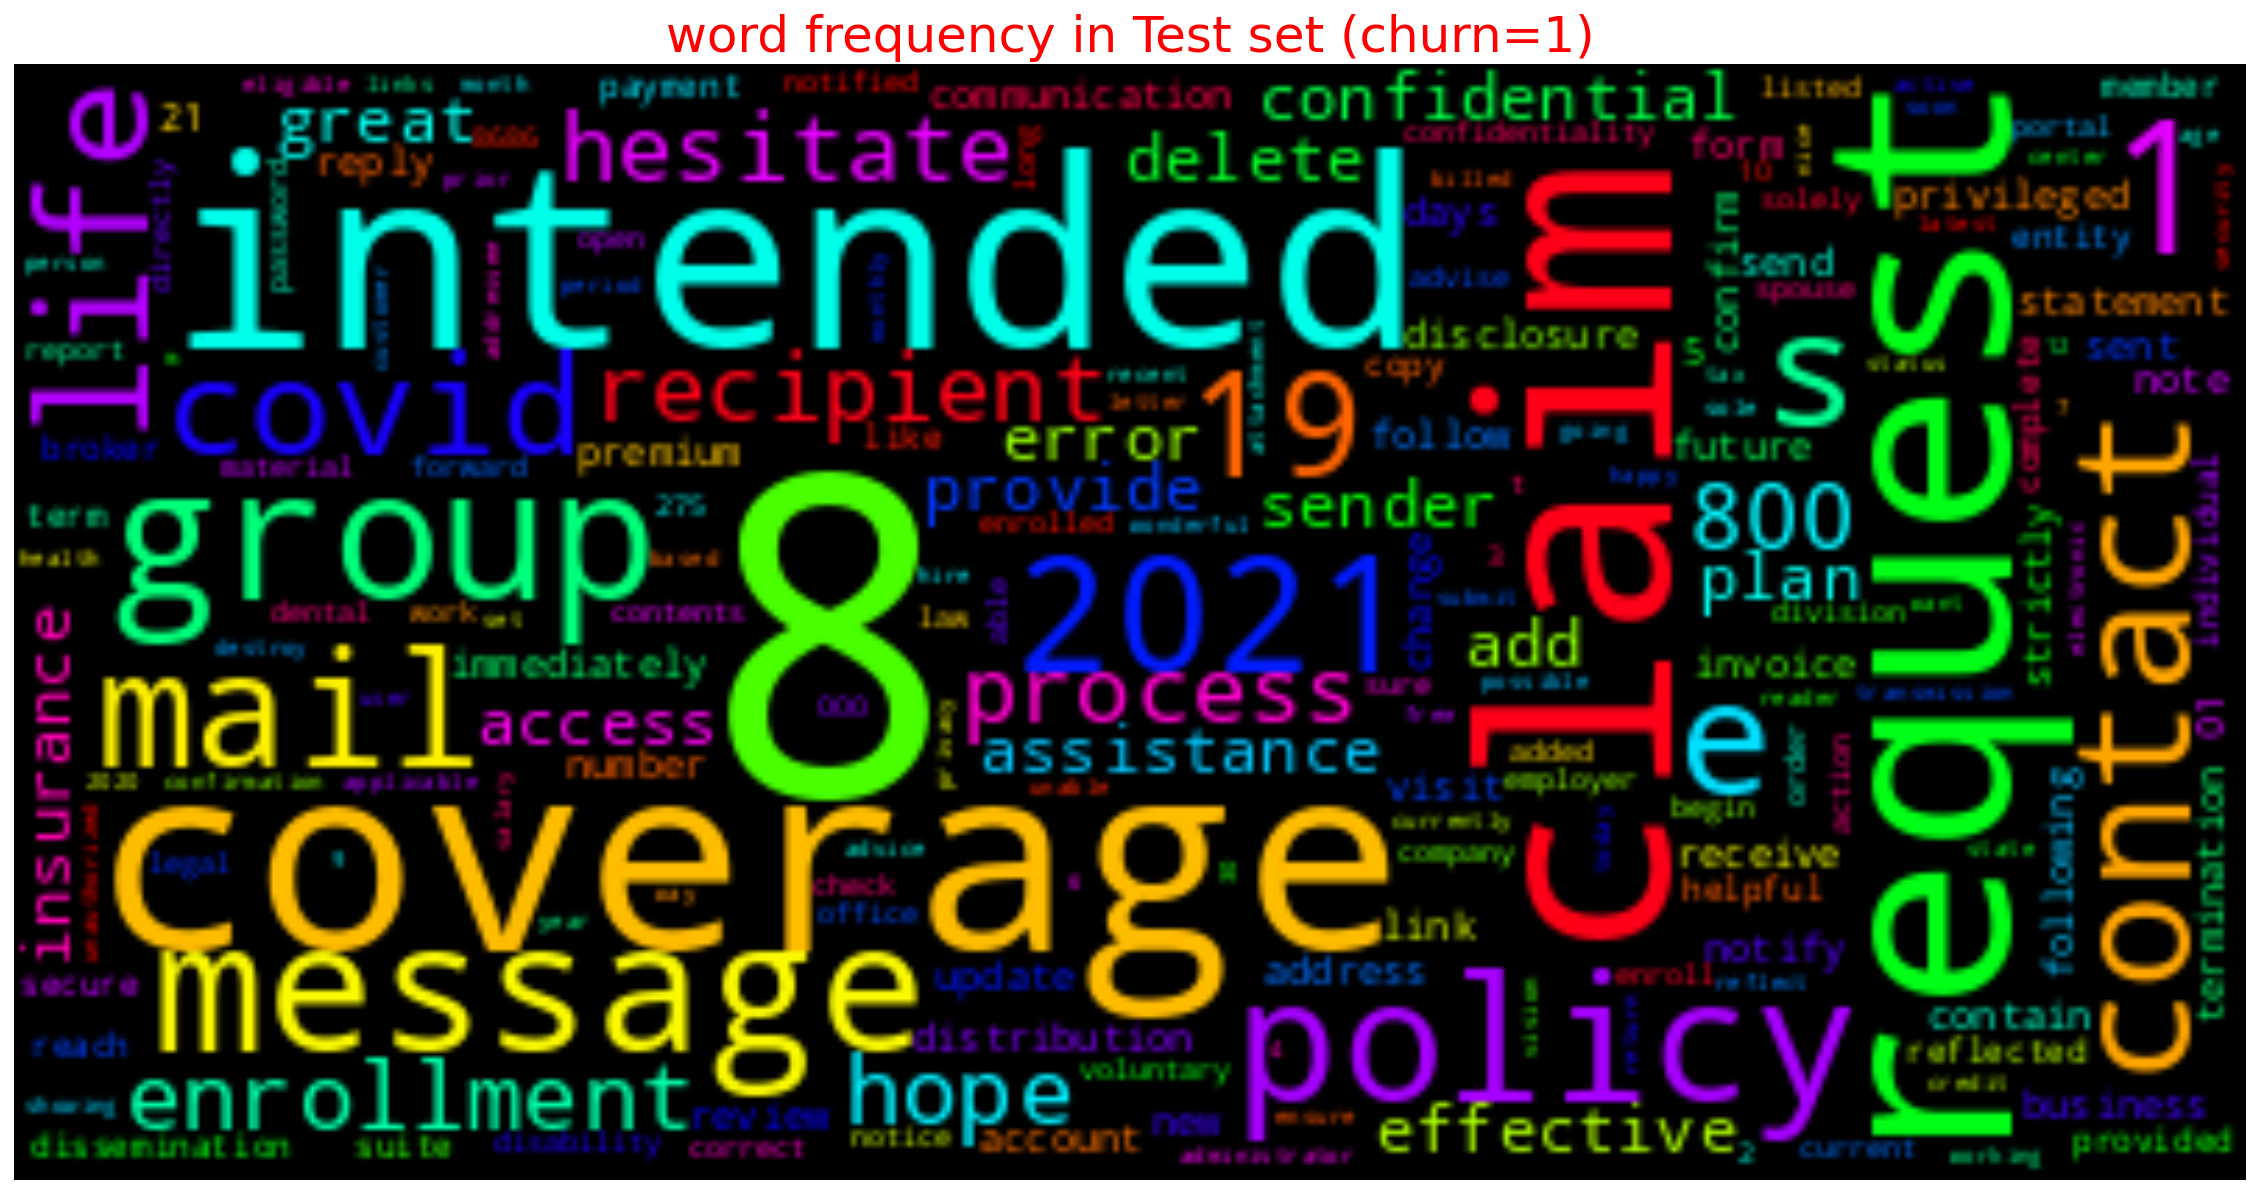

In [25]:
test_word_positive=[]
df_test_positive=df_test[df_test["churn"]==1]
for index, row in tqdm(df_test_positive.iterrows(), total=df_test_positive.shape[0]):
    text_tokens = word_tokenize(row["Full_TextBody"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    test_word_positive.extend(filter_text)
    
test_dict=Counter(test_word_positive)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(test_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Test set (churn=1)", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
def dummy_fun(doc):
    return doc.split()

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(input="content",analyzer='word',tokenizer=dummy_fun,max_features=1000)

In [27]:
n=50
vectorizer.fit(df_train["Full_TextBody"])
df_tfidf = vectorizer.transform(df_train["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_train = np.argsort(df_tfidf.toarray()).flatten()[::-1]
train_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_train":vocab[tfidf_train][:n]})

vectorizer.fit(df_test["Full_TextBody"])
df_tfidf = vectorizer.transform(df_test["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_test = np.argsort(df_tfidf.toarray()).flatten()[::-1]
test_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_test":vocab[tfidf_test][:n]})

pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner")

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


rank  tfidf_train       tfidf_test
0      0         pull         earnings
1      1         1777       definition
2      2        94596         material
3      3       walnut         pandemic
4      4        creek       commission
5      5          250          current
6      6       census         business
7      7           ca              law
8      8            8           change
9      9        needs          prepare
10    10          not        corporate
11    11      calling           salary
12    12       review        violation
13    13    wonderful             west
14    14          you   retransmission
15    15         time             weve
16    16       report         eligible
17    17        thank            drive
18    18         know                8
19    19        claim            visit
20    20     hesitate           client
21    21   assistance            flyer
22    22       please             best
23    23     coverage         computer
24    24      request              100
25    25       policy          renewal
26    26        group             page
27    27         with             note
28    28   department           person
29    29       dental         included
30    30    dependent           policy
31    31     delivery            based
32    32    deduction           entity
33    33       delete  confidentiality
34    34        delay            suite
35    35   definition              and
36    36  description            claim
37    37      deliver          provide
38    38     declined               or
39    39  destruction           recent
40    40     decision          forward
41    41        death           member
42    42         days                2
43    43          day        insurance
44    44         date             able
45    45         data             time
46    46       damage            needs
47    47            d                e
48    48     customer          contain
49    49    currently             mail

In [28]:
n=50

df_train_churn=df_train[df_train["churn"]==1]
vectorizer.fit(df_train_churn["Full_TextBody"])
df_tfidf = vectorizer.transform(df_train_churn["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_train = np.argsort(df_tfidf.toarray()).flatten()[::-1]
train_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_train":vocab[tfidf_train][:n]})

df_test_churn=df_test[df_test["churn"]==1]
vectorizer.fit(df_test_churn["Full_TextBody"])
df_tfidf = vectorizer.transform(df_test_churn["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_test = np.argsort(df_tfidf.toarray()).flatten()[::-1]
test_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_test":vocab[tfidf_test][:n]})

pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner")

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


rank   tfidf_train     tfidf_test
0      0             8        subject
1      1        access         stated
2      2      password        carrier
3      3          york           rate
4      4         reset        advised
5      5       getting             30
6      6        person         notice
7      7     temporary           days
8      8        census         change
9      9          time           note
10    10         needs      deduction
11    11     reinstate            day
12    12         covid          death
13    13           new       decision
14    14         claim       declined
15    15            is            you
16    16          feel         defect
17    17          plan          delay
18    18            it           data
19    19           log         delete
20    20       current        deliver
21    21          free       delivery
22    22          able           date
23    23          line       customer
24    24            me         damage
25    25          help              d
26    26           can          cycle
27    27         thank     department
28    28      security      currently
29    29            19        current
30    30             s          cross
31    31          list       critical
32    32        thanks         credit
33    33          life         create
34    34    retirement          covid
35    35         visit        covered
36    36      offering         dental
37    37       company        destroy
38    38      enrolled      dependent
39    39        column    description
40    40         added             do
41    41      informed       division
42    42           you            div
43    43        format   distribution
44    44         newly     distribute
45    45  specifically  dissemination
46    46      resolved    disseminate
47    47         title  dismemberment
48    48       address           disk
49    49      choosing        discuss

In [132]:
pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner").shape

(50, 3)

In [133]:
pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner").drop_duplicates().shape

(50, 3)

In [126]:
train_data=email_all['train']
test_data=email_all['test']
train_data.set_format(type="pandas")
df_train=train_data[:]
test_data.set_format(type="pandas")
df_test=test_data[:]
from datasets import Dataset
hf_train=Dataset.from_pandas(df_train)
hf_test=Dataset.from_pandas(df_test)
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
        
for text in ["Full_TextBody", "Latest_TextBody"]:
    hf_train=hf_train.map(lambda x : tokenizer(x[text]),batched=True)
    hf_train=hf_train.remove_columns("attention_mask")
    hf_train=hf_train.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    # hf_dataset = hf_dataset.filter(lambda x: len(x[text+"_input_ids"]) > self.min_tokens)
    
    hf_test=hf_test.map(lambda x : tokenizer(x[text]),batched=True)
    hf_test=hf_test.remove_columns("attention_mask")
    hf_test=hf_test.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    
hf_train.set_format(type="pandas")
df_train=hf_train[:]
hf_test.set_format(type="pandas")
df_test=hf_test[:]

df_train["Full_Words_length"] = df_train["Full_TextBody_input_ids"].apply(len)
df_test["Full_Words_length"] = df_test["Full_TextBody_input_ids"].apply(len)

import textwrap
import random

df_test_v1=df_test[(df_test.churn==1) & (df_test.Full_Words_length<=512)]
df_test_v1=df_test_v1.dropna(subset=["Client_TextBody"])
# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=150) 

exam_1 = df_test_v1["Full_TextBody"]
exam_2 = df_test_v1["Client_TextBody"]
exam_3 = df_test_v1["Latest_TextBody"]

# Randomly choose some examples.
for i in range(10):
    random.seed(101+i)
    j = random.choice(exam_1.index)
    
    print('')
    print("*"*50)
    print('*********  Full TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_1[j]))
    print('')
    print("*"*50)
    print('*********  Client TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_2[j]))
    print('')
    print("*"*50)
    print('*********  Latest Parent_ID TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_3[j]))
    print('')
    print("*"*200)


**************************************************
*********  Full TextBody ********
**************************************************

please see the attached screenshot for turf tenders.nothing on left side trying to term employee. please advise how to fix this cidimage.pngda.fe

**************************************************
*********  Client TextBody ********
**************************************************

please see the attached screenshot for turf tenders.nothing on left side trying to term employee. please advise how to fix this cidimage.pngda.fe

**************************************************
*********  Latest Parent_ID TextBody ********
**************************************************

please see the attached screenshot for turf tenders.nothing on left side trying to term employee. please advise how to fix this cidimage.pngda.fe

*************************************************************************************************************************************